In [1]:
import itertools
import datetime
import time
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from hmmlearn import hmm
import requests as req
from tqdm import tqdm
import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
## 간단한 예제 더미 데이터로 테스트

model            = hmm.GaussianHMM(n_components = 3, covariance_type = 'full')
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_  = np.array([
                                [0.7, 0.2, 0.1],
                                [0.3, 0.5, 0.2],
                                [0.3, 0.3, 0.4]
                            ])
model.means_     = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_    = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(100)

In [3]:
def augment_features(df):
    
    fracocp = (df['Close'] - df['Open']) / df['Open']
    frachp  = (df['High']  - df['Open']) / df['Open']
    fraclp  = (df['Low']   - df['Open']) / df['Open']
    
    new_df  = pd.DataFrame({
                            'delOpenClose' : fracocp,
                            'delHighOpen'  : frachp,
                            'delLowOpen'   : fraclp
                        })
    
    new_df.set_index(df.index)
    return new_df


def extract_features(df):
    return np.column_stack((df['delOpenClose'], df['delHighOpen'], df['delLowOpen']))

In [4]:
df = yf.download('^GSPC', start = '2000-01-01', end = '2021-08-01')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [5]:
train_data, test_data = train_test_split(df, test_size = 0.2, shuffle = False)

In [6]:
model              = hmm.GaussianHMM(n_components = 10)
feature_train_data = augment_features(train_data)
features_train     = extract_features(feature_train_data)

model.fit(features_train)

GaussianHMM(n_components=10)

In [7]:
test_augmented       = augment_features(test_data)
fracocp              = test_augmented['delOpenClose']
frachp               = test_augmented['delHighOpen']
fraclp               = test_augmented['delLowOpen']

sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
sample_space_frachp  = np.linspace(frachp.min() , frachp.max() , 10)
sample_space_fraclp  = np.linspace(fraclp.min() , fraclp.max() , 10)

In [8]:
possible_outcomes = np.array(
                        list(itertools.product(sample_space_fracocp,
                                               sample_space_frachp,
                                               sample_space_fraclp
                                              )))

In [9]:
num_latent_days        = 50
num_days_to_predict    = 300
predicted_close_prices = []

for idx in tqdm(range(num_days_to_predict)):
    
    start_index    = max(0, idx - num_latent_days)
    end_index      = max(0, idx)
    previous_data  = extract_features(
                        augment_features(test_data.iloc[start_index : end_index])
                     )
    
    outcome_scores = []
    for outcome in possible_outcomes:
        
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))
        
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_prices.append(test_data.iloc[idx]['Open'] * (1 + most_probable_outcome[0]))

100% 300/300 [36:10<00:00,  7.24s/it]


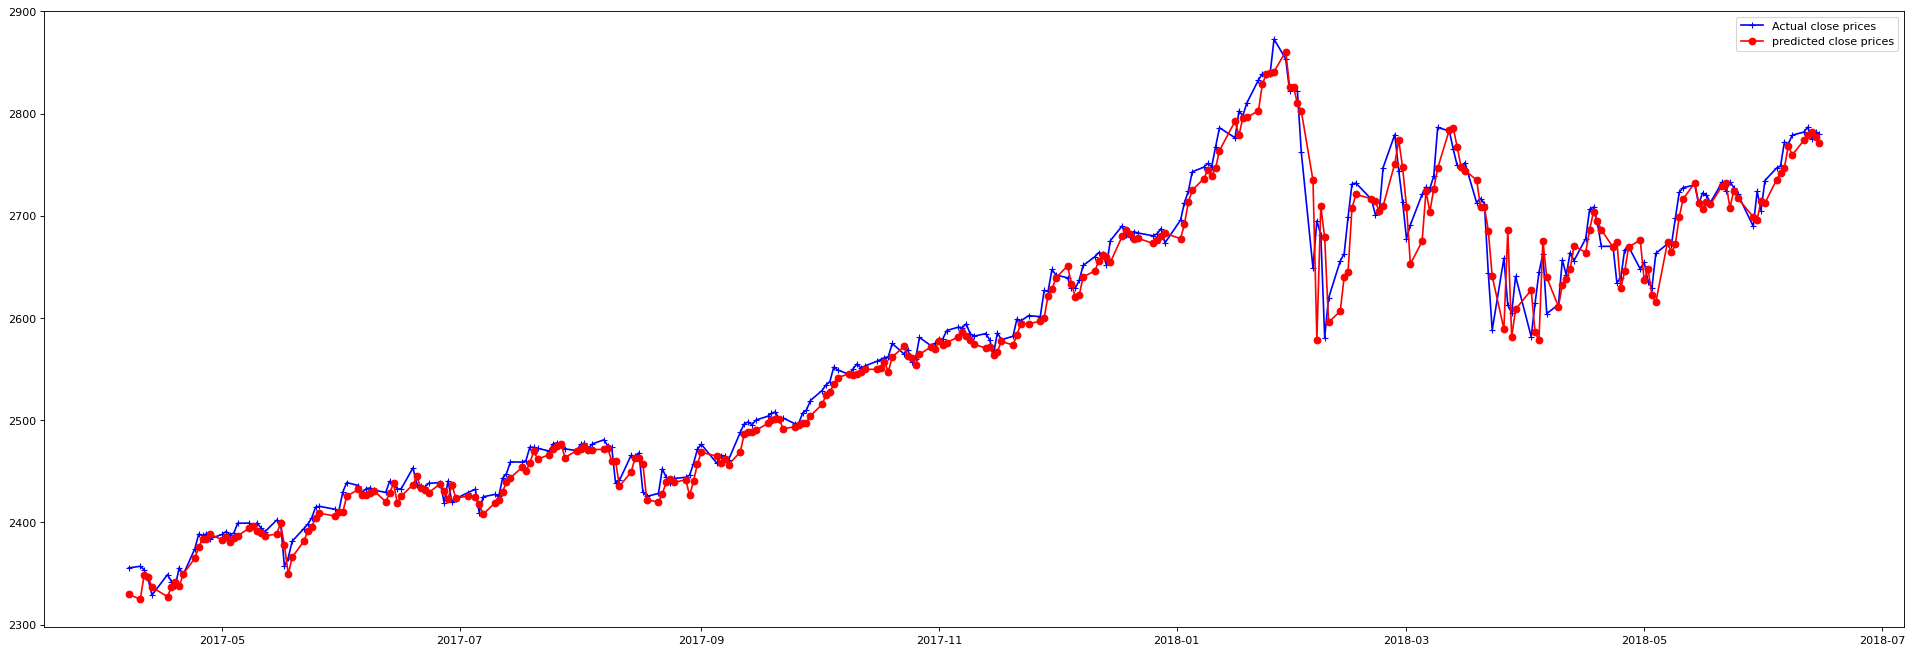

In [10]:
plt.figure(figsize = (30, 10), dpi = 80)

x_axis = np.array(test_data.index[0:num_days_to_predict], dtype = 'datetime64[ms]')

plt.plot(x_axis, test_data.iloc[0: num_days_to_predict]['Close'], 'b+-', label = 'Actual close prices')
plt.plot(x_axis, predicted_close_prices, 'ro-', label = 'predicted close prices')

plt.legend()
plt.show()

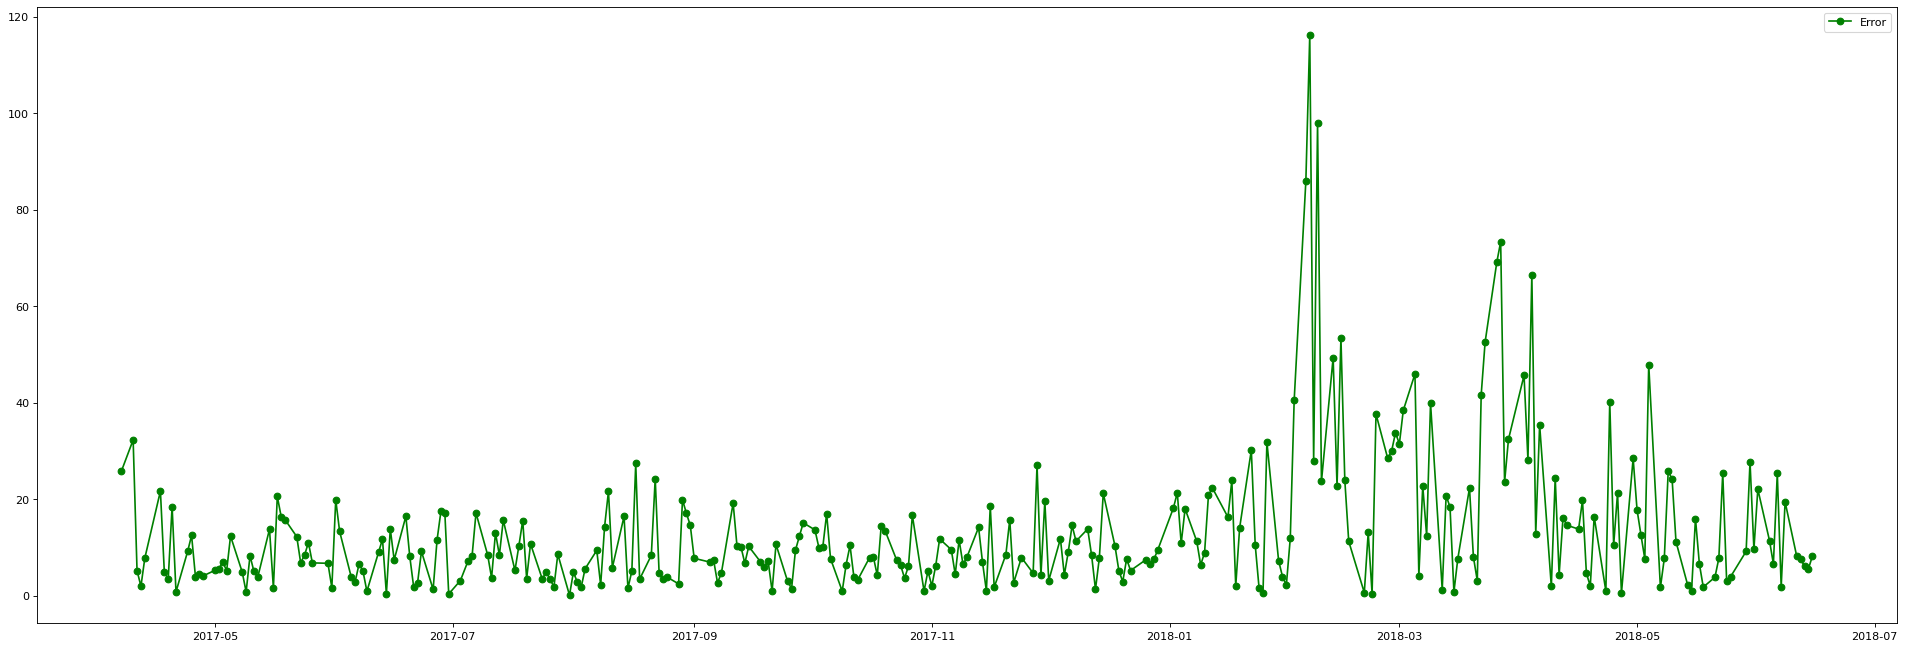

In [11]:
ae = abs(test_data.iloc[0: num_days_to_predict]['Close'] - predicted_close_prices)

plt.figure(figsize = (30, 10), dpi = 80)
plt.plot(x_axis, ae, 'go-', label = 'Error')
plt.legend()
plt.show()

In [12]:
print(f'Max  error observed : {ae.max():.3f}')
print(f'Min  error observed : {ae.min():.3f}')
print(f'Mean error observed : {ae.mean():.3f}')

Max  error observed : 116.131
Min  error observed : 0.058
Mean error observed : 13.148


In [13]:
baseline_num_latent_days = 50
baseline_num_components  = 10
baseline_num_steps       = 50
num_days_to_predict      = 100

num_latent_days_values   = [10, 20, 30, 40, 50, 60]
num_components_values    = [4, 6, 8, 10, 12, 14]
num_steps_values         = [10, 20, 40, 50]

In [14]:
mae_num_steps = []
for num_component in num_components_values:
    
    model = hmm.GaussianHMM(n_components = num_component)
    model.fit(features_train)
    
    for num_step in num_steps_values:
        
        sample_space_fracocp   = np.linspace(fracocp.min(), fracocp.max(), num_step)
        sample_space_fraclp    = np.linspace(fraclp.min() , fraclp.max() , int(num_step / 5))
        sample_space_frachp    = np.linspace(frachp.min() , frachp.max() , int(num_step / 5))
        
        possible_outcomes      = np.array(list(itertools.product(
                                          sample_space_fracocp, sample_space_frachp, sample_space_fraclp
                                    )))
        predicted_close_prices = []
        for idx in tqdm(range(num_days_to_predict)):
            
            start_index    = max(0, idx - baseline_num_latent_days)
            end_index      = max(0, idx)
            
            previous_data  = extract_features(augment_features(test_data.iloc[start_index : end_index]))
            outcome_scores = []
            
            for outcome in possible_outcomes:
                
                total_data = np.row_stack((previous_data, outcome))
                outcome_scores.append(model.score(total_data))
                
            most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
            predicted_close_prices.append(test_data.iloc[idx]['Open'] * (1 + most_probable_outcome[0]))
            
        mae = (abs(test_data.iloc[0 : num_days_to_predict]['Close'] - predicted_close_prices)).mean()
        mae_num_steps.append(mae)

100% 100/100 [00:05<00:00, 18.36it/s]
100% 100/100 [00:37<00:00,  2.64it/s]
100% 100/100 [05:12<00:00,  3.13s/it]
100% 100/100 [10:18<00:00,  6.18s/it]
100% 100/100 [00:05<00:00, 17.17it/s]
100% 100/100 [00:40<00:00,  2.48it/s]
100% 100/100 [05:29<00:00,  3.29s/it]
100% 100/100 [10:35<00:00,  6.36s/it]
100% 100/100 [00:05<00:00, 17.01it/s]
100% 100/100 [00:44<00:00,  2.26it/s]
100% 100/100 [05:37<00:00,  3.37s/it]
100% 100/100 [11:01<00:00,  6.62s/it]
100% 100/100 [00:06<00:00, 15.89it/s]
100% 100/100 [00:46<00:00,  2.15it/s]
100% 100/100 [05:56<00:00,  3.57s/it]
100% 100/100 [11:56<00:00,  7.16s/it]
100% 100/100 [00:06<00:00, 15.14it/s]
100% 100/100 [00:50<00:00,  1.98it/s]
100% 100/100 [06:29<00:00,  3.90s/it]
100% 100/100 [12:25<00:00,  7.45s/it]
100% 100/100 [00:07<00:00, 13.95it/s]
100% 100/100 [00:53<00:00,  1.86it/s]
100% 100/100 [07:02<00:00,  4.22s/it]
100% 100/100 [13:33<00:00,  8.14s/it]


ValueError: x and y must have same first dimension, but have shapes (4,) and (24,)

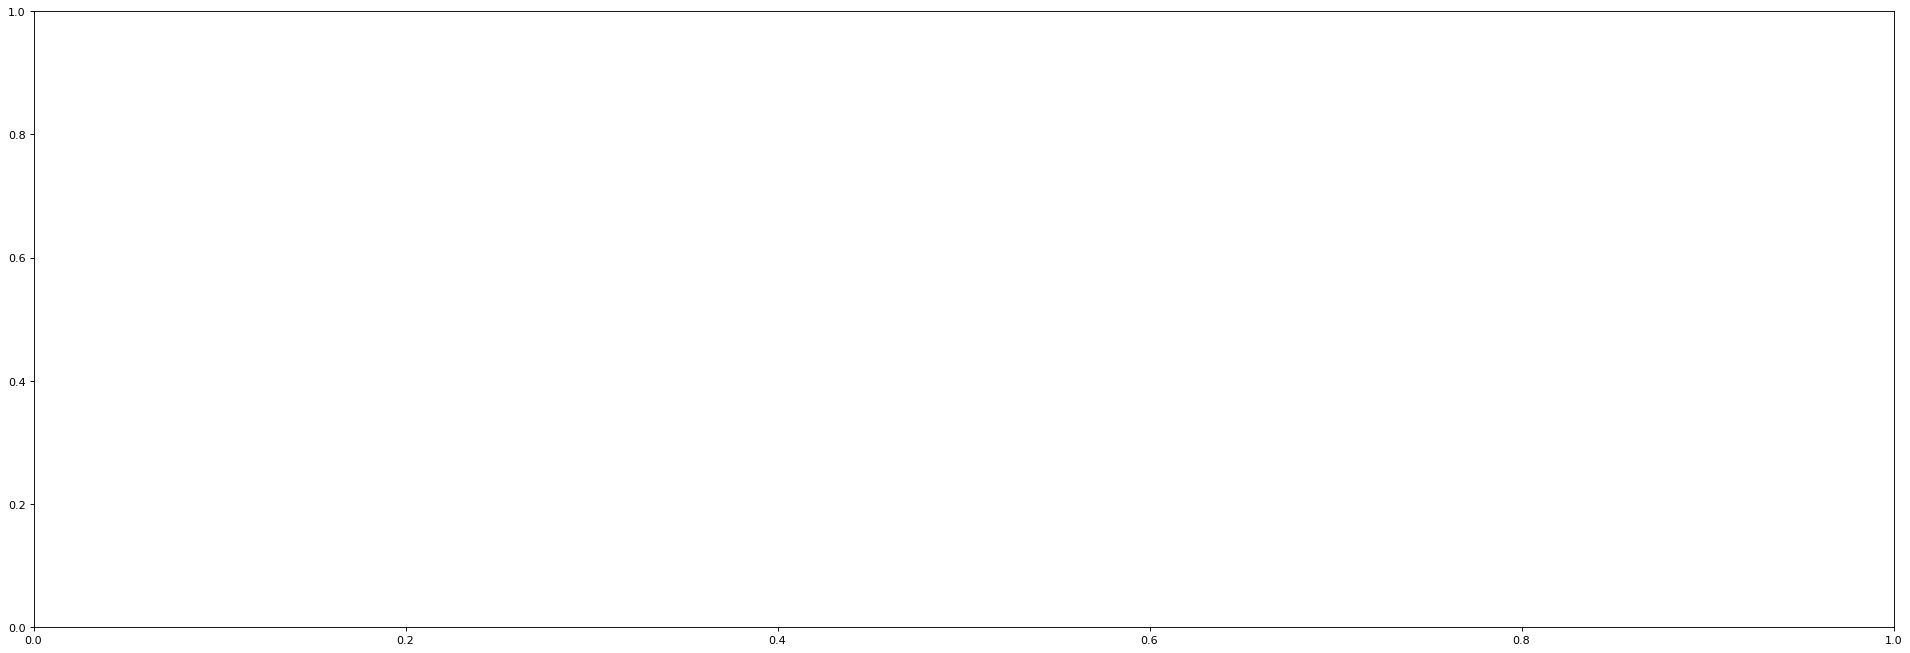

In [15]:
plt.figure(figsize = (30, 10), dpi = 80)
plt.plot(num_steps_values, mae_num_steps, 'go-', label = 'Error')
plt.xlabel('# of hidden states')
plt.ylabel('MAE')
plt.legend()
plt.show()